# **Bibliotecas**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import base

import joblib
import warnings
import IPython


IPython.display.clear_output(wait=True)

In [2]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# **Importação dos dados**

In [3]:
# lendo os dados
INPUT_DIR = 'C:/Users/Igor/Desktop/PIBIC 2021 e 2022/Dados'

calendar = pd.read_csv(f'{INPUT_DIR}/calendar.csv')
selling_prices = pd.read_csv(f'{INPUT_DIR}/sell_prices.csv')
sample_submission = pd.read_csv(f'{INPUT_DIR}/sample_submission.csv')
sales_train_val = pd.read_csv(f'{INPUT_DIR}/sales_train_validation.csv') #sales_train d_1 até d_1913
sales_train_eva = pd.read_csv(f'{INPUT_DIR}/sales_train_evaluation.csv') #sales_train d_1 até d_1941

# NOTE: o banco sales_train_eva contempla o sales_train_val e ainda adciona observações das vendas dos dias d_1914 - d_1941

# **Análise exploratória dos dados**

In [4]:
calendar

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


In [5]:
selling_prices

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.00
6841117,WI_3,FOODS_3_827,11618,1.00
6841118,WI_3,FOODS_3_827,11619,1.00
6841119,WI_3,FOODS_3_827,11620,1.00


In [6]:
sample_submission


,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60976,FOODS_3_824_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60977,FOODS_3_825_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60978,FOODS_3_826_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
sales_train_val

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,2,0,0,0,0,0,1,0,0,1
30486,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
30487,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,2,1,0,2,0,1,0,0,1,0
30488,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,1,0,0,1,0,3,1,3


In [8]:
sales_train_eva

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,1,0,3,0,1,1,0,0,1,1
30486,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
30487,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,0,0,1,2,0,1,0,1,0,2
30488,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,1,1,1,4,6,0,1,1,1,0


Vamos tentar identificar o tamanho do ciclo sazonal das séries a partir de uma visão geral do nível mais agregado para as vendas

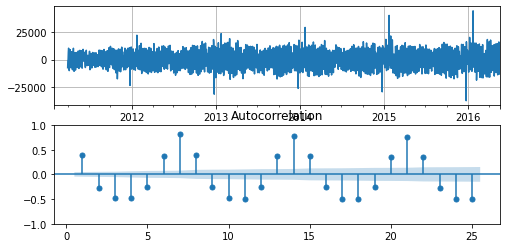

In [9]:
# Verificar o tamanho do ciclo sazonal -> ciclo sazonal semanal

a = base.dict_1_eva['all'] - base.dict_1_eva['all'].rolling(30).mean()

a = a.diff(30)

fig, (ax1,ax2) = plt.subplots(2,1, figsize=(8,4))

a.plot(grid=True, ax = ax1)


# Plot ACF
plot_acf(a.dropna(), ax=ax2, lags=25, zero=False)
plt.show()



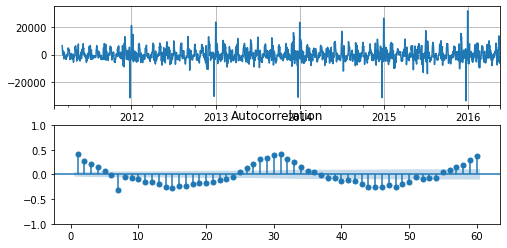

In [10]:
# Verificar o tamanho do ciclo sazonal -> ciclo sazonal mensal

a = base.dict_1_eva['all'] - base.dict_1_eva['all'].rolling(30).mean()

a = a.diff(7)

fig, (ax1,ax2) = plt.subplots(2,1, figsize=(8,4))

a.plot(grid=True, ax = ax1)


# Plot ACF
plot_acf(a.dropna(), ax=ax2, lags=60, zero=False)
plt.show()

Tudo indica que as séries possuem mais de 1 ciclo sazonal, ou ao menos:

* Ciclo sazonal semanal
* Ciclo sazonal mensal
* Um possível ciclo sazonal anual

In [160]:
warnings.filterwarnings("ignore")

base.attach_datas_val(base.dict_9_val['WI_1_HOUSEHOLD_2'], 'WI_1', 'HOUSEHOLD_2').head(3)

,wm_yr_wk,weekday,wday,month,year,d,snap_CA,snap_TX,snap_WI,#sales,...,event_type_1_Sporting,event_type_1_nan,event_name_2_Cinco De Mayo,event_name_2_Easter,event_name_2_Father's day,event_name_2_OrthodoxEaster,event_name_2_nan,event_type_2_Cultural,event_type_2_Religious,event_type_2_nan
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,11101,Saturday,1,1,2011,d_1,0,0,0,148.0,...,0,1,0,0,0,0,1,0,0,1
2011-01-30,11101,Sunday,2,1,2011,d_2,0,0,0,151.0,...,0,1,0,0,0,0,1,0,0,1
2011-01-31,11101,Monday,3,1,2011,d_3,0,0,0,66.0,...,0,1,0,0,0,0,1,0,0,1


In [12]:
base.attach_datas_val(base.dict_9_val['WI_1_HOUSEHOLD_2'], 'WI_1', 'HOUSEHOLD_2').columns

Index(['wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'd', 'snap_CA',
       'snap_TX', 'snap_WI', '#sales', 'media_preco_de_venda', 'filtro',
       'event_name_1_Chanukah End', 'event_name_1_Christmas',
       'event_name_1_Cinco De Mayo', 'event_name_1_ColumbusDay',
       'event_name_1_Easter', 'event_name_1_Eid al-Fitr',
       'event_name_1_EidAlAdha', 'event_name_1_Father's day',
       'event_name_1_Halloween', 'event_name_1_IndependenceDay',
       'event_name_1_LaborDay', 'event_name_1_LentStart',
       'event_name_1_LentWeek2', 'event_name_1_MartinLutherKingDay',
       'event_name_1_MemorialDay', 'event_name_1_Mother's day',
       'event_name_1_NBAFinalsEnd', 'event_name_1_NBAFinalsStart',
       'event_name_1_NewYear', 'event_name_1_OrthodoxChristmas',
       'event_name_1_OrthodoxEaster', 'event_name_1_Pesach End',
       'event_name_1_PresidentsDay', 'event_name_1_Purim End',
       'event_name_1_Ramadan starts', 'event_name_1_StPatricksDay',
       'event_name_1_Supe

##  **AJUSTE DOS MODELOS PARA VALIDATION**

In [145]:
#b = base.attach_datas_val(base.dict_9_val['WI_1_HOUSEHOLD_2'], 'WI_1', 'HOUSEHOLD_2')
#
#e1 = base.attach_datas_val(base.dict_9_val['WI_1_HOUSEHOLD_2'], 'WI_1', 'HOUSEHOLD_2')[['wday', 'media_preco_de_venda', 'snap_WI']][0:1941]
#a =  1 - (np.array(base.attach_datas_eva(base.dict_9_eva['WI_1_HOUSEHOLD_2'], 'WI_1', 'HOUSEHOLD_2')['event_name_1_nan'])*
#np.array(base.attach_datas_eva(base.dict_9_eva['WI_1_HOUSEHOLD_2'], 'WI_1', 'HOUSEHOLD_2')['event_name_2_nan']))
#a = pd.Series(a, index = base.attach_datas_eva(base.dict_9_eva['WI_1_HOUSEHOLD_2'], 'WI_1', 'HOUSEHOLD_2').index)
#e1['evento'] = a[0:1941]

#result = pm.auto_arima(
#    b['#sales'][0:1913], d = 1, start_p=0, start_q=0, max_p=3, max_q=3,
#    seasonal = True, m = 7, D=1, start_P=0, start_Q=0, max_P=1, max_Q=1,
#    information_criterion='aic', error_action='ignore', stepwise=True,
#    X = e1[0:1913]
#)

#result.summary()

Ajuste

In [ ]:
for i in (base.dict_9_val.keys()):

    b = base.attach_datas_val(base.dict_9_val[i], i[0:4], i[5:])

    e1 = base.attach_datas_val(base.dict_9_val[i], i[0:4], i[5:])[['wday', 'media_preco_de_venda', 'snap_'+str(i[0:2])]][0:1941]
    a =  1 - (np.array(base.attach_datas_val(base.dict_9_val[i], i[0:4], i[5:])['event_name_1_nan'])*
    np.array(base.attach_datas_val(base.dict_9_val[i], i[0:4], i[5:])['event_name_2_nan']))
    a = pd.Series(a, index = base.attach_datas_val(base.dict_9_val[i], i[0:4], i[5:]).index)
    e1['evento'] = a[0:1941]
        
    result = pm.auto_arima(
        b['#sales'][0:1913], d = 1, start_p=0, start_q=0, max_p=3, max_q=3,
        seasonal = True, m = 7, D=1, start_P=0, start_Q=0, max_P=1, max_Q=1,
        information_criterion='aic', error_action='ignore', stepwise=True,
        X = e1[0:1913]
        )

    INPUT_PATH = 'C:/Users/Igor/Desktop/PIBIC 2021 e 2022/Modelos_validation'

    filepath = f'{INPUT_PATH}/great_model_' + str(i) + str('.pkl')

    joblib.dump(result, filepath)

    # result = joblib.load(filepath)
    

    if (str('FOODS') in str(i) == True):

        z1 = []
        for j1 in sample_submission['id']:
            if (str(j1).find(str(b['filtro'][0][0:7])) != -1) & (str(j1).find(str(b['filtro'][0][8:])) != -1):
                z1.append(j1)

        for k1 in z1:
            
            forecast = result.predict(28, X= e1[1913:1941])
            sample_submission[sample_submission['id']==k1] = np.round((base.dict_12_val[k1].sum()/base.dict_9_val[i].sum())*forecast, 0)
    
    elif (str('HOBBIES') in str(i) == True):

        z2 = []
        for j2 in sample_submission['id']:
            if (str(j2).find(str(b['filtro'][0][0:9])) != -1) & (str(j2).find(str(b['filtro'][0][10:])) != -1):
                z2.append(j2)

        for k2 in z2:
            
            forecast = result.predict(28, X= e1[1913:1941])
            sample_submission[sample_submission['id']==k2] = np.round((base.dict_12_val[k2].sum()/base.dict_9_val[i].sum())*forecast, 0)

    elif (str('HOUSEHOLD') in str(i) == True):

        z3 = []
        for j3 in sample_submission['id']:
            if (str(j3).find(str(b['filtro'][0][0:11])) != -1) & (str(j3).find(str(b['filtro'][0][12:])) != -1):
                z3.append(j3)

        for k3 in z3:
            
            forecast = result.predict(28, X= e1[1913:1941])
            sample_submission[sample_submission['id']==k3] = np.round((base.dict_12_val[k3].sum()/base.dict_9_val[i].sum())*forecast, 0)    

##  **AJUSTE DOS MODELOS PARA EVALUATION**

ajuste

### RASCUNHO 

In [146]:
#result.predict(28, X= e1[1913:1941])


In [147]:
# DESCENDO NO NIVEL DE AGREGACAO ATÉ O NIVEL MAIS BAIXO A PARTIR DA PREVISÃO COM DICT_9

#np.round((base.dict_12_val['HOUSEHOLD_2_001_WI_1_validation'].sum()/base.dict_9_val['WI_1_HOUSEHOLD_2'].sum())*result.predict(28, X= e1[1913:1941]), 0)

### RASCUNHO - STEPWISE PARA EXOG = 


In [ ]:
#attach_datas_eva(dict_9_eva['WI_1_HOUSEHOLD_2'], 'WI_1', 'HOUSEHOLD_2').columns

In [148]:
# DESCENDO NO NIVEL DE AGREGACAO ATÉ O NIVEL MAIS BAIXO A PARTIR DA PREVISÃO COM DICT_9

#round((base.dict_12_eva['FOODS_1_001_CA_1_evaluation'].sum()/base.dict_9_eva['CA_1_FOODS_1'].sum())*297, 0)

In [ ]:
#attach_datas_val(dict_9_val['WI_1_HOUSEHOLD_2'], 'WI_1', 'HOUSEHOLD_2')['media_preco_de_venda']

In [ ]:
#attach_datas_val(dict_9_val['WI_1_HOUSEHOLD_2'], 'WI_1', 'HOUSEHOLD_2')['media_preco_de_venda'].shift(-7)